In [1]:
## EXPLANATIONS OF CODE ADDED IN COMMENTS UNDER "ANS" TO DIFFERENTIATE
## FROM INSTRUCTIONS IN DOCSTRINGS

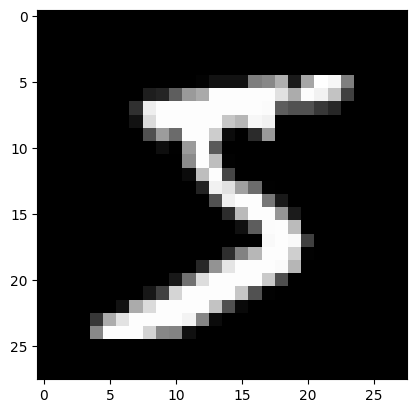

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import edf
import mnist_loader

train_images, train_labels = mnist_loader.load_mnist(section="training", path="MNIST")
test_images, test_labels = mnist_loader.load_mnist(section="testing", path="MNIST")

plt.imshow(train_images[0], cmap="gray", interpolation="nearest")
plt.show()

In [3]:
"""we will reshape the 28x28 grayscale images as 
784-dimensional vectors, which will be the network's inputs"""

train_images = train_images.reshape(len(train_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [4]:
"""we manually set the number of input features (784)
and number of classes (10) which will be used to
define the model"""

nInputs = 784
nLabels = 10

"""below, MLPparams is an EDF ParameterPackage whose
purpose is to define and store the parameters of the model,
while MLPgraph is a function that implements the model's
forward pass -- in this case, just a 1-hidden layer MLP"""


class MLPparams(edf.ParameterPackage):
    def __init__(self, nInputs, nHiddens, nLabels):
        self.first = edf.AffineParams(nInputs, nHiddens)
        self.last = edf.AffineParams(nHiddens, nLabels)


def MLPsigmoidgraph(Phi, x):
    h = edf.Sigmoid(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))


"""we then construct a MLP with 64 hidden units"""

np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPsigmoidgraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [5]:
"""the following functions are used to train the network.
training is done by iterating over mini-batches of size 'batch_size'
and updating the model's parameters with SGD"""


def run_epoch(batch_size, data, labels, xnode, ynode, probnode, lossnode=None):
    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples // batch_size
    for i in range(num_batches):
        start, end = i * batch_size, (i + 1) * batch_size
        xnode.value = train_images[start:end]
        ynode.value = train_labels[start:end]
        edf.Forward()
        total_err += np.sum(
            np.not_equal(np.argmax(probnode.value, axis=1), ynode.value)
        )
        if lossnode:
            edf.Backward(lossnode)
            edf.SGD()
        if i > 0 and i % 400 == 0:
            print("\t Batch {}/{}".format(i, num_batches))
    return 100 * total_err / num_samples


def train(num_epochs, batch_size, xnode, ynode, probnode, lossnode):
    train_err_log = []
    test_err_log = []
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))
        train_err = run_epoch(
            batch_size, train_images, train_labels, xnode, ynode, probnode, lossnode
        )
        train_err_log.append(train_err)
        print("\t Training Error {:.2f} %".format(train_err))
        test_err = run_epoch(
            len(test_images), test_images, test_labels, xnode, ynode, probnode
        )
        test_err_log.append(test_err)
        print("\t Test Error {:.2f} %".format(test_err))
    return train_err_log, test_err_log

In [6]:
"""now, we are ready to train the network. we can choose SGD's learning rate
by changing edf.learning_rate, which we will set as 0.5 for now."""

num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(
    num_epochs, batch_size, xnode, ynode, probnode, lossnode
)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.51 %
	 Test Error 7.89 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.37 %
	 Test Error 5.77 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 4.56 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.10 %
	 Test Error 3.78 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.49 %
	 Test Error 3.25 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.09 %
	 Test Error 2.85 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.78 %
	 Test Error 2.60 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.49 %
	 Test Error 2.35 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.24 %
	 Test Error 2.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.01 %
	 Test Error 2.06 %


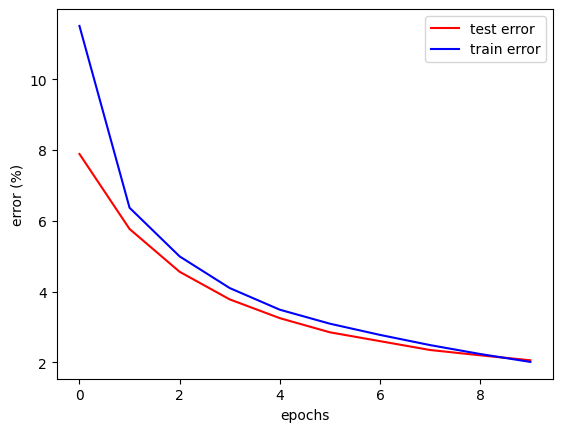

<Figure size 640x480 with 0 Axes>

In [7]:
"""we can then plot the error per epoch on the training and test data"""

plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color="red")
plt.plot(np.arange(len(train_err_log)), train_err_log, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

In [8]:
"""next, you have to implement a ReLU activation function ReLU(x) = max(0,x).
implement the forward and backward methods of the following class. use the
provided EDF source code to understand what each method should do. note that
since ReLU has no parameters, it might be helpful to base your implementation
on how the Sigmoid EDF CompNode is implemented."""


class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here
        bounded = np.minimum(10, self.x.value)
        ## ANS: Above line adapted from EDF.py
        # added to prevent overflow numerical warnings for 10 layer model
        self.value = np.where(bounded > 0, bounded, 0)
        ## ANS: The above line is the ReLU function

    def backward(self):
        # implementation goes here
        grad = np.where(self.value > 0, 1, 0)
        ## ANS: The above line is is the differential of ReLU
        self.x.addgrad(self.grad * grad)

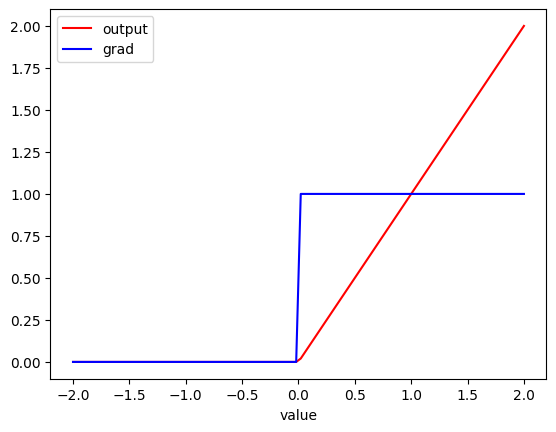

<Figure size 640x480 with 0 Axes>

In [9]:
"""the code below will plot the output and gradients computed by your
implementation of the ReLU component above. check if the plots match
ReLU(x) and dReLU/dx(x) as a sanity test of your implementation."""

values = np.linspace(-2, 2, 100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = ReLU(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color="red")
plt.plot(values, param.grad[0], color="blue")
plt.legend(["output", "grad"], loc="upper left")
plt.show()
plt.clf()

## ANS: Sanity check seems to work fine!

In [10]:
"""now, train the same network as before but with a ReLU activation
in the hidden layer instead of a Sigmoid."""


def MLPrelugraph(Phi, x):
    h = ReLU(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))


np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPrelugraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [11]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(
    num_epochs, batch_size, xnode, ynode, probnode, lossnode
)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 7.98 %
	 Test Error 6.81 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.70 %
	 Test Error 4.17 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.73 %
	 Test Error 2.78 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.25 %
	 Test Error 2.38 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.80 %
	 Test Error 2.17 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.59 %
	 Test Error 1.97 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.28 %
	 Test Error 2.07 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.11 %
	 Test Error 1.66 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.94 %
	 Test Error 1.33 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.87 %
	 Test Error 1.80 %


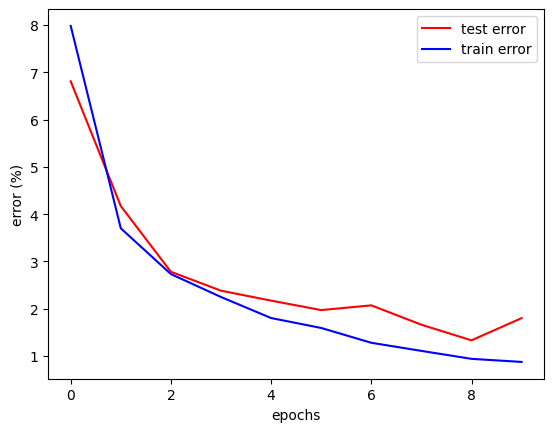

<Figure size 640x480 with 0 Axes>

In [12]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color="red")
plt.plot(np.arange(len(train_err_log)), train_err_log, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

## ANS: ReLU looks to work well, and reduces our error rate.
# The test error rate also seems to fluctuate a little towards the end,
# maybe signifying that more epochs might not meaningfully the needle?

In [13]:
"""now, implement the Tanh activation function by filling the missing
code in the forward and backward methods below. it might be helpful to derive
a relationship between Tanh and Sigmoid so that you can re-use parts of 
EDF's Sigmoid code."""


class Tanh(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        # implementation goes here
        bounded = np.maximum(-10, np.minimum(10, self.x.value))
        ## ANS: Above line borrowed directly from Sigmoid, as Tanh and sigmoid
        # have similar S shaped curves
        self.value = np.tanh(self.x.value)
        ## ANS: Above is a call to the tanh function
        # Also equivalent to  (2 / (1 + np.exp(-2*bounded))) - 1

    def backward(self):
        # implementation goes here
        self.x.addgrad(self.grad * (1 - np.power(self.value, 2)))
        ## ANS: The derivative of tanh(x) is 1 - tanh^2(x)

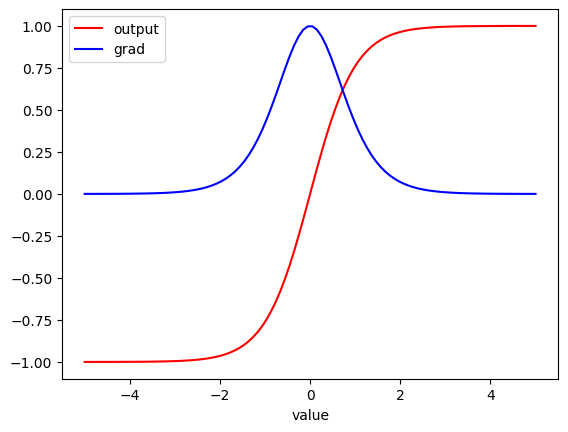

<Figure size 640x480 with 0 Axes>

In [14]:
"""again, make sure that the output and gradients plotted below are correct."""

values = np.linspace(-5, 5, 100)
edf.clear_compgraph()
param = edf.Parameter(values[None, :])
output = Tanh(param)

edf.Forward()
edf.Backward(output)

plt.xlabel("value")
plt.plot(values, output.value[0], color="red")
plt.plot(values, param.grad[0], color="blue")
plt.legend(["output", "grad"], loc="upper left")
plt.show()
plt.clf()

In [15]:
"""you can then train a network with a Tanh activation function instead
of Sigmoid/ReLU."""


def MLPtanhgraph(Phi, x):
    h = Tanh(edf.Affine(Phi.first, x))
    return edf.Softmax(edf.Affine(Phi.last, h))


np.random.seed(1234)
edf.clear_compgraph()
xnode = edf.Input()
ynode = edf.Input()
nHiddens = 64
Phi = MLPparams(nInputs, nHiddens, nLabels)
probnode = MLPtanhgraph(Phi, xnode)
lossnode = edf.LogLoss(probnode, ynode)

In [16]:
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.5
train_err_log, test_err_log = train(
    num_epochs, batch_size, xnode, ynode, probnode, lossnode
)

Epoch: 1/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.29 %
	 Test Error 6.01 %
Epoch: 2/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.21 %
	 Test Error 4.13 %
Epoch: 3/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.05 %
	 Test Error 2.93 %
Epoch: 4/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.38 %
	 Test Error 2.26 %
Epoch: 5/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.95 %
	 Test Error 1.82 %
Epoch: 6/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.60 %
	 Test Error 1.60 %
Epoch: 7/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.31 %
	 Test Error 1.41 %
Epoch: 8/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 1.07 %
	 Test Error 1.28 %
Epoch: 9/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.84 %
	 Test Error 1.20 %
Epoch: 10/10
	 Batch 400/937
	 Batch 800/937
	 Training Error 0.66 %
	 Test Error 1.21 %


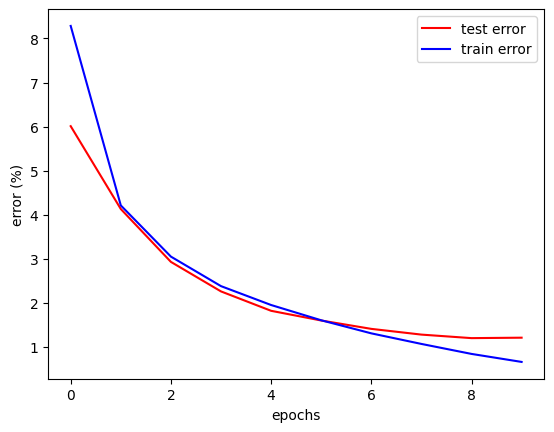

<Figure size 640x480 with 0 Axes>

In [17]:
plt.xlabel("epochs")
plt.ylabel("error (%)")
plt.plot(np.arange(len(test_err_log)), test_err_log, color="red")
plt.plot(np.arange(len(train_err_log)), train_err_log, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

## ANS: This also works well, with a similar error rate in this case to the ReLU function

In [18]:
"""next, let's check how changing the learning rate affects
the model's train and test error. you should implement a way
to collect the network's final train/test errors for each of
the learning rates in the array below. you should do this for
MLPs with sigmoid and relu activations, and select the best
learning rate for each of the two networks (w/ sigmoid 
and w/ relu activations)"""

"""add code below to train MLPs with sigmoid activations.
your code should populate the arrays train_err_per_lr and
test_err_per_lr, such that they contain the train and test
errors of models trained with each learning rate in the
learning_rates arrays, i.e. train_err_per_lr[1] should contain
the final train error of a sigmoid MLP trained with a learning
rate of 1.0"""

num_epochs = 5
batch_size = 64
learning_rates = [5.0, 1.0, 0.5, 0.1]

train_err_per_lr = []
test_err_per_lr = []

# implementation goes here

for lr in learning_rates:
    print("#### LEARING RATE : ", lr)
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)
    edf.learning_rate = lr
    train_err_log, test_err_log = train(
        num_epochs, batch_size, xnode, ynode, probnode, lossnode
    )
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])
    ## ANS: We collect the relevant error rates here, by appending the
    # final epochs error rate to the lists

#### LEARING RATE :  5.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.90 %
	 Test Error 7.51 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.98 %
	 Test Error 6.27 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.00 %
	 Test Error 5.59 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.41 %
	 Test Error 4.72 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.87 %
	 Test Error 4.53 %
#### LEARING RATE :  1.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.08 %
	 Test Error 6.81 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.96 %
	 Test Error 4.68 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.71 %
	 Test Error 3.51 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.98 %
	 Test Error 2.86 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.51 %
	 Test Error 2.39 %
#### LEARING RATE :  0.5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training

In [19]:
# implementation goes here
best_sigmoid_lr = np.array(learning_rates)[test_err_per_lr == np.min(test_err_per_lr)][
    0
]
## ANS: Here, we take the smallest test error rate, and extract the
# corresponding learning rate

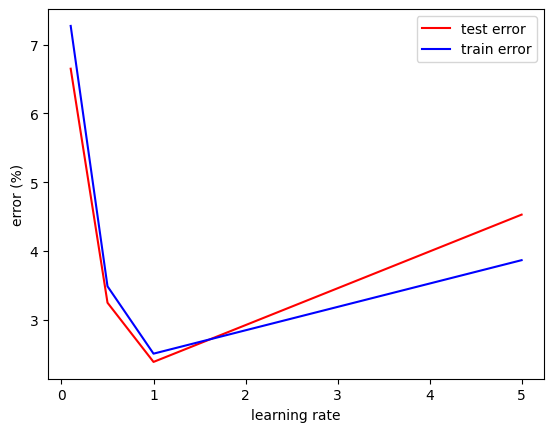

<Figure size 640x480 with 0 Axes>

In [20]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color="red")
plt.plot(learning_rates, train_err_per_lr, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

## ANS: Quite clearly, we tend to have the best test error rates at
# a learning rate of 1.0

In [21]:
"""now, repeat the experiment above but with a MLP with
a ReLU activation functions in the hidden layer"""

train_err_per_lr = []
test_err_per_lr = []

# implementation goes here

num_epochs = 5
batch_size = 64
learning_rates = [5.0, 1.0, 0.5, 0.1]

for lr in learning_rates:
    print("#### LEARING RATE : ", lr)
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)
    edf.learning_rate = lr
    train_err_log, test_err_log = train(
        num_epochs, batch_size, xnode, ynode, probnode, lossnode
    )
    train_err_per_lr.append(train_err_log[-1])
    test_err_per_lr.append(test_err_log[-1])
    ## ANS: We collect the relevant error rates here, by appending the
    # final epochs error rate to the lists

#### LEARING RATE :  5.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.17 %
	 Test Error 90.20 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 90.27 %
	 Test Error 90.20 %
#### LEARING RATE :  1.0
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 13.83 %
	 Test Error 9.00 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.19 %
	 Test Error 6.55 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.21 %
	 Test Error 5.19 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.63 %
	 Test Error 4.98 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.32 %
	 Test Error 5.33 %
#### LEARING RATE :  0.5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	

In [22]:
# implementation goes here
best_relu_lr = np.array(learning_rates)[test_err_per_lr == np.min(test_err_per_lr)][0]
## ANS: Here, we take the smallest test error rate, and extract the
# corresponding learning rate

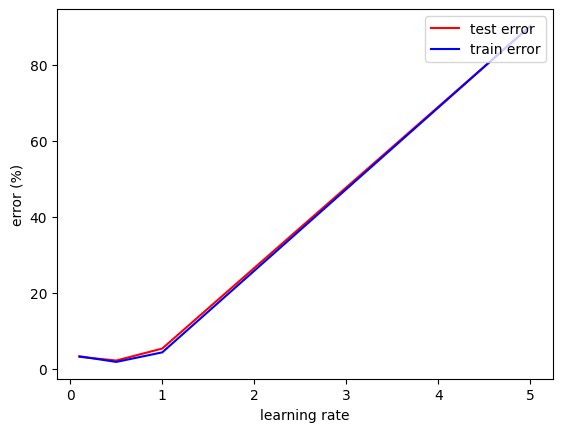

<Figure size 640x480 with 0 Axes>

In [23]:
plt.xlabel("learning rate")
plt.ylabel("error (%)")
plt.plot(learning_rates, test_err_per_lr, color="red")
plt.plot(learning_rates, train_err_per_lr, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

## ANS: Here, we tend to have the best test error rates at a learning rate of 0.5
# However, an interesting point to note is that here for a learning rate of 5.0,
# we do not have convergence! The rate is too high for this given model to converge.
# Given the ~90% error rate, it seems that the model is predicting everything with a single label

In [24]:
"""finally, we will check how the number of hidden layers affects
the model's performance. start by re-implementing MLPparams such that
it supports multiple layers (note the new nLayers argument). each of the
nLayers-1 hidden layers should have nHiddens neurons."""


class MLPparams(edf.ParameterPackage):
    def __init__(self, nInputs, nHiddens, nLabels, nLayers):
        # implementation goes here
        self.first = edf.AffineParams(nInputs, nHiddens)
        self.hidden_layers_len = nLayers - 1
        self.hidden_layers = [
            edf.AffineParams(nHiddens, nHiddens) for i in range(self.hidden_layers_len)
        ]
        self.last = edf.AffineParams(nHiddens, nLabels)
        ## ANS: Here, we are defining the length of additional hidden layers as nLayers-1.
        # Putting nLayers as 1, should give us back the same model as before!


"""you should also re-implement MLPsigmoidgraph and MLPrelugraph
so that they both have support for multiple layers, following your
re-implementation of MLPparams above."""


def MLPsigmoidgraph(Phi, x):
    # implementation goes here
    h = []
    h.append(edf.Sigmoid(edf.Affine(Phi.first, x)))
    for i in range(Phi.hidden_layers_len):
        h.append(edf.Sigmoid(edf.Affine(Phi.hidden_layers[i], h[i])))
    return edf.Softmax(edf.Affine(Phi.last, h[-1]))
    ## ANS: For both sigmoid and ReLU, we create a list of hidden layers.
    # This also should behave in the same way as before for nLayers=1


def MLPrelugraph(Phi, x):
    # implementation goes here
    h = []
    h.append(ReLU(edf.Affine(Phi.first, x)))
    for i in range(Phi.hidden_layers_len):
        h.append(ReLU(edf.Affine(Phi.hidden_layers[i], h[i])))
    return edf.Softmax(edf.Affine(Phi.last, h[-1]))

In [25]:
"""similarly to the exploration with different learning rates,
you will see how the depth of the network affects its performance,
first for a sigmoid network. fill the missing code to populate
train_err_per_depth and test_err_per_depth accordingly"""

edf.learning_rate = best_sigmoid_lr
num_epochs = 5
batch_size = 64
num_layers = [2, 4, 6]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here

for nl in num_layers:
    print("#### NUM LAYERS : ", nl)
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels, nl)
    probnode = MLPsigmoidgraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)
    train_err_log, test_err_log = train(
        num_epochs, batch_size, xnode, ynode, probnode, lossnode
    )
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])

#### NUM LAYERS :  2
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 15.71 %
	 Test Error 8.37 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.36 %
	 Test Error 6.06 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.77 %
	 Test Error 4.58 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.93 %
	 Test Error 3.66 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.40 %
	 Test Error 3.22 %
#### NUM LAYERS :  4
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 85.73 %
	 Test Error 67.00 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 31.14 %
	 Test Error 17.53 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 8.18 %
	 Test Error 8.24 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.37 %
	 Test Error 5.30 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.05 %
	 Test Error 4.31 %
#### NUM LAYERS :  6
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 89

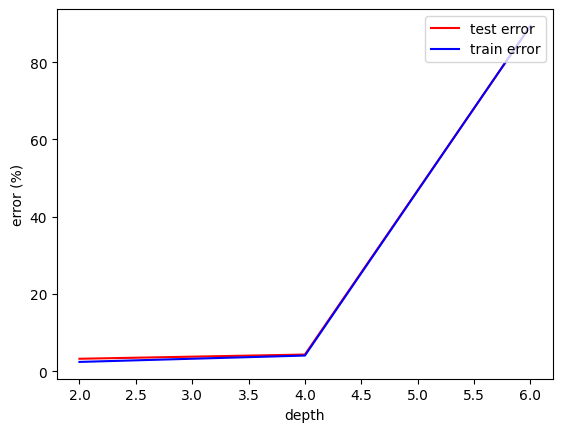

<Figure size 640x480 with 0 Axes>

In [26]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color="red")
plt.plot(num_layers, train_err_per_depth, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

## ANS: Here (and for the same graph below for ReLU), we see that for
# the highest depth, there is no convergence.
# This could be due to vanishing/exploding gradients,
# and batch normalisation could help!

In [27]:
"""repeat the above experiment but for a ReLU MLP"""

edf.learning_rate = best_relu_lr
num_epochs = 5
batch_size = 64
num_layers = [3, 5, 10]

train_err_per_depth = []
test_err_per_depth = []

# implementation goes here

for nl in num_layers:
    print("#### NUM LAYERS : ", nl)
    np.random.seed(1234)
    edf.clear_compgraph()
    xnode = edf.Input()
    ynode = edf.Input()
    nHiddens = 64
    Phi = MLPparams(nInputs, nHiddens, nLabels, nl)
    probnode = MLPrelugraph(Phi, xnode)
    lossnode = edf.LogLoss(probnode, ynode)
    train_err_log, test_err_log = train(
        num_epochs, batch_size, xnode, ynode, probnode, lossnode
    )
    train_err_per_depth.append(train_err_log[-1])
    test_err_per_depth.append(test_err_log[-1])

#### NUM LAYERS :  3
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 14.15 %
	 Test Error 8.65 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.15 %
	 Test Error 8.83 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.98 %
	 Test Error 4.64 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.28 %
	 Test Error 3.89 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 2.90 %
	 Test Error 3.71 %
#### NUM LAYERS :  5
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 24.84 %
	 Test Error 11.44 %
Epoch: 2/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 6.79 %
	 Test Error 7.37 %
Epoch: 3/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.34 %
	 Test Error 5.27 %
Epoch: 4/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.40 %
	 Test Error 4.29 %
Epoch: 5/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.92 %
	 Test Error 4.50 %
#### NUM LAYERS :  10
Epoch: 1/5
	 Batch 400/937
	 Batch 800/937
	 Training Error 78.

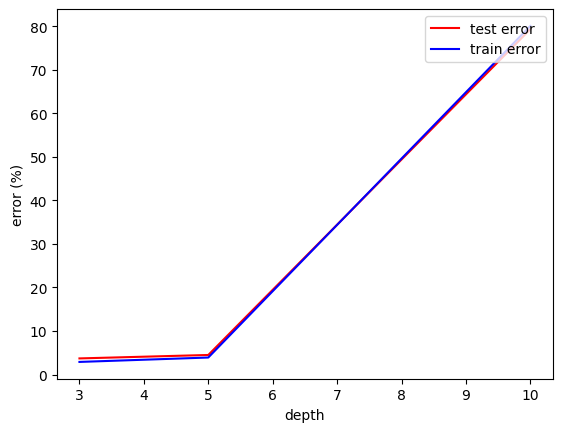

<Figure size 640x480 with 0 Axes>

In [28]:
plt.xlabel("depth")
plt.ylabel("error (%)")
plt.plot(num_layers, test_err_per_depth, color="red")
plt.plot(num_layers, train_err_per_depth, color="blue")
plt.legend(["test error", "train error"], loc="upper right")
plt.show()
plt.clf()

In [29]:
## ANS: Through testing, my estimate is that convergence starts to fail
# at the threshold of 5 layers for the sigmoid, and 10 layers for the ReLU